In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.stats import ttest_rel, levene

import mar
import preprocessing

In [2]:
def validate_directory(pat_num):
    data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
    output_dir = os.path.join(os.path.dirname(os.getcwd()), "output")

    if not os.path.exists(os.path.join(data_dir, f'Patient{pat_num}')):
        os.makedirs(os.path.join(data_dir, f'Patient{pat_num}'))

    if not os.path.exists(os.path.join(output_dir, f'Patient{pat_num}')):
        os.makedirs(os.path.join(output_dir, f'Patient{pat_num}'))

    return data_dir, output_dir

def get_data(data_dir, pat_num):
    mar_data = preprocessing.load_mar_data(data_dir, pat_num)
    sickbay_data = preprocessing.load_sickbay_data(data_dir, pat_num)
    # sbs_data = preprocessing.load_retro_data(data_dir, pat_num, ignore_default=True)
    accel_data = preprocessing.load_accel_data(data_dir, pat_num)
    # ecg_data = preprocessing.load_ecg_data(data_dir, pat_num)

    return mar_data, sickbay_data, accel_data

def get_drug_doses(mar_data):
    mar_narcotics, mar_paralytics, mar_alpha_agonists, mar_ketamines, mar_propofols, mar_etomidates, mar_benzodiazepines = mar.filter_mar(mar_data)
    mar_classes = {'narcotics': mar_narcotics, 'paralytics': mar_paralytics, 'alpha_agonists': mar_alpha_agonists, 'ketamines': mar_ketamines, 'propofols': mar_propofols, 'etomidates': mar_etomidates, 'benzodiazepines': mar_benzodiazepines}

    drug_doses = {}

    for mar_class in mar_classes:
        if mar_classes[mar_class].shape[0] < 1:
            continue

        for drug_name in mar.classes()[mar_class]:
            drug_df = mar.filter_drug(mar_classes[mar_class], drug_name)
            
            if drug_df.shape[0] < 1:
                continue

            drug_doses[drug_name] = mar.calculate_doses(drug_df)

    return drug_doses

def get_metrics(sickbay_data, accel_data):
    metrics = {
        'heart_rate': pd.DataFrame({
            'time': pd.to_datetime(sickbay_data['time']),
            'heart_rate': sickbay_data['heart_rate']}),
        'respiratory_rate': pd.DataFrame({
            'time': pd.to_datetime(sickbay_data['time']),
            'respiratory_rate': sickbay_data['respiratory_rate']}),
        'acceleration': pd.DataFrame({
            'time': pd.to_datetime(accel_data['time']),
            'acceleration': accel_data['a']}),}
    
    start = max(df['time'].min() for df in metrics.values())
    stop = min(df['time'].max() for df in metrics.values())
    
    for metric, df in metrics.items():
        df = df[(df['time'] >= start) & (df['time'] <= stop)].reset_index(drop=True)
        df[metric] = df[metric].astype(float)

        numeric_cols = df.select_dtypes(include=np.number).columns
        df[numeric_cols] = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()

        metrics[metric] = df

    return metrics, start, stop

def get_drug_df(drug_doses, drug, start, stop):
    drug_df = drug_doses[drug]
    drug_df = drug_df[(drug_df['time'] >= pd.to_datetime(start)) & (drug_df['time'] <= pd.to_datetime(stop))].reset_index(drop=True)
    drug_df = drug_df[drug_df['bolus_dose'] != 0].reset_index(drop=True)

    return drug_df

def get_df(drug_df, metrics, minus, plus):
    times, doses = [], []

    hr_means_before = []
    hr_std_before = []
    hr_means_after = []
    hr_std_after = []

    rr_means_before = []
    rr_std_before = []
    rr_means_after = []
    rr_std_after = []

    a_means_before = []
    a_std_before = []
    a_means_after = []
    a_std_after = []

    for i in range(len(drug_df)):
        time = drug_df.iloc[i, 0]
        dose = drug_df.iloc[i, 3]

        hr = metrics['heart_rate']
        hr_before = hr[(hr['time'] >= pd.to_datetime(time) - pd.Timedelta(minutes=minus)) & (hr['time'] <= pd.to_datetime(time))].reset_index(drop=True)
        hr_after = hr[(hr['time'] >= pd.to_datetime(time)) & (hr['time'] <= pd.to_datetime(time) + pd.Timedelta(minutes=plus))].reset_index(drop=True)
        
        rr = metrics['respiratory_rate']
        rr_before = rr[(rr['time'] >= pd.to_datetime(time) - pd.Timedelta(minutes=minus)) & (rr['time'] <= pd.to_datetime(time))].reset_index(drop=True)
        rr_after = rr[(rr['time'] >= pd.to_datetime(time)) & (rr['time'] <= pd.to_datetime(time) + pd.Timedelta(minutes=plus))].reset_index(drop=True)

        a = metrics['acceleration']
        a_before = a[(a['time'] >= pd.to_datetime(time) - pd.Timedelta(minutes=minus)) & (a['time'] <= pd.to_datetime(time))].reset_index(drop=True)
        a_after = a[(a['time'] >= pd.to_datetime(time)) & (a['time'] <= pd.to_datetime(time) + pd.Timedelta(minutes=plus))].reset_index(drop=True)

        times.append(time)
        doses.append(dose)

        hr_means_before.append(np.mean(hr_before['heart_rate']))
        hr_std_before.append(np.std(hr_before['heart_rate']))
        hr_means_after.append(np.mean(hr_after['heart_rate']))
        hr_std_after.append(np.std(hr_after['heart_rate']))

        rr_means_before.append(np.mean(rr_before['respiratory_rate']))
        rr_std_before.append(np.std(rr_before['respiratory_rate']))
        rr_means_after.append(np.mean(rr_after['respiratory_rate']))
        rr_std_after.append(np.std(rr_after['respiratory_rate']))

        a_means_before.append(np.mean(a_before['acceleration']))
        a_std_before.append(np.std(a_before['acceleration']))
        a_means_after.append(np.mean(a_after['acceleration']))
        a_std_after.append(np.std(a_after['acceleration']))

    df = pd.DataFrame({
        'time': times,
        'dose': doses,
        'hr_mean_before': hr_means_before,
        'hr_std_before': hr_std_before,
        'hr_mean_after': hr_means_after,
        'hr_std_after': hr_std_after,
        'rr_mean_before': rr_means_before,
        'rr_std_before': rr_std_before,
        'rr_mean_after': rr_means_after,
        'rr_std_after': rr_std_after,
        'a_mean_before': a_means_before,
        'a_std_before': a_std_before,
        'a_mean_after': a_means_after,
        'a_std_after': a_std_after,})

    return df

def triangle_filter(window=10):
    L = window
    n = np.arange(L, dtype=float)
    center = (L - 1) / 2.0
    h = 1.0 - np.abs(n - center) / (center + 1.0)
    h = np.maximum(h, 0)

    h = h / np.sum(h)

    return h.astype(float)

def pitman_morgan_test(x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    D = x - y
    S = x + y

    r = np.corrcoef(D, S)[0, 1]
    n = len(x)

    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p_val = 2 * (1 - t.cdf(abs(t_stat), df=n - 2))

    return t_stat, p_val


In [7]:
pat_nums = [2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26]
# pat_nums = [14]
drugs = ['fentanyl', 'hydromorphone', 'morphine', 'oxycodone', 'methadone']

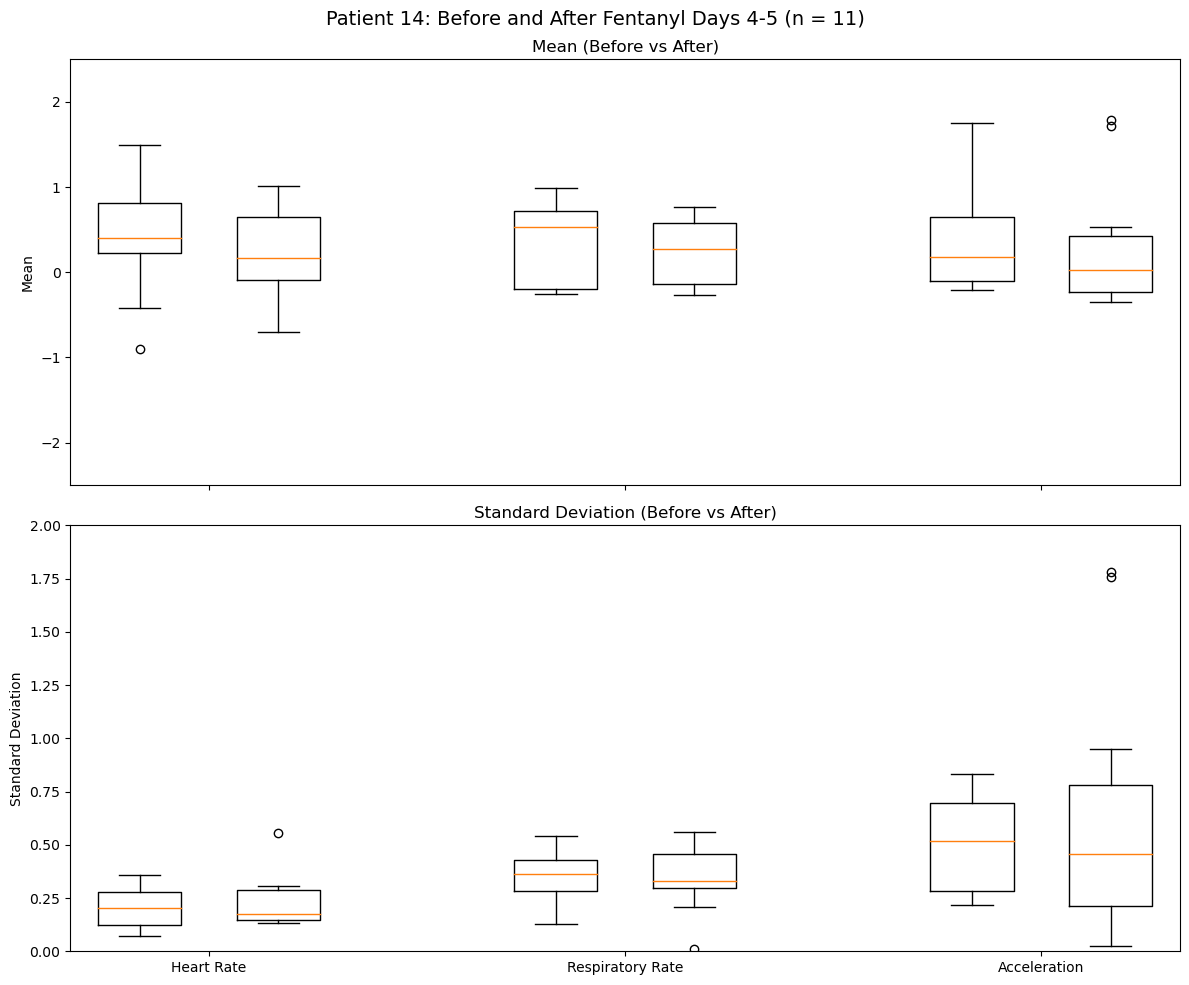

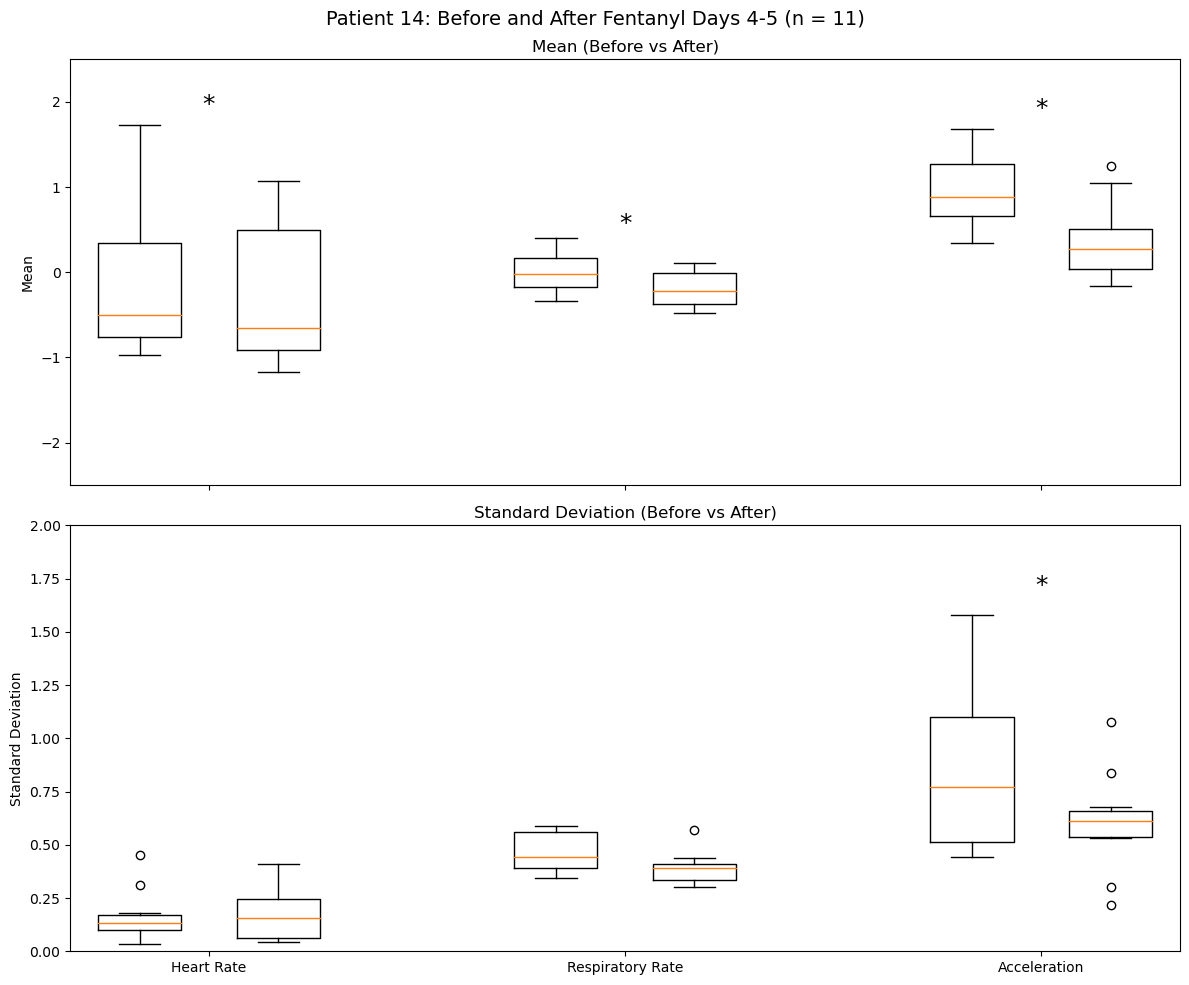

In [35]:
metrics = ['hr', 'rr', 'a']
labels = ['Before', 'After']

data_dir, output_dir = validate_directory(14)
# pat_nums = [14]
pat_nums = [2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26]
drug_title = 'Fentanyl'
drug = 'fentanyl'

for pat_num in pat_nums:
    try:
        df = pd.read_csv(
            os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug}_metrics.csv'),
            index_col=False
        )

        df['time'] = pd.to_datetime(df['time'])
        df['date'] = df['time'].dt.date

        df1 = pd.DataFrame({
            'time': [],
            'dose': [],
            'hr_mean_before': [],
            'hr_std_before': [],
            'hr_mean_after': [],
            'hr_std_after': [],
            'rr_mean_before': [],
            'rr_std_before': [],
            'rr_mean_after': [],
            'rr_std_after': [],
            'a_mean_before': [],
            'a_std_before': [],
            'a_mean_after': [],
            'a_std_after': [],})
        
        df2 = pd.DataFrame({
            'time': [],
            'dose': [],
            'hr_mean_before': [],
            'hr_std_before': [],
            'hr_mean_after': [],
            'hr_std_after': [],
            'rr_mean_before': [],
            'rr_std_before': [],
            'rr_mean_after': [],
            'rr_std_after': [],
            'a_mean_before': [],
            'a_std_before': [],
            'a_mean_after': [],
            'a_std_after': [],})

        count = 0

        for day, df_day in df.groupby('date'):
            if count < 3:
                df1 = pd.concat([df1, df_day])
            else:
                df2 = pd.concat([df2, df_day])
            
            count += 1


        for i, df in enumerate([df1, df2]):
            # -------------------- Prepare Data --------------------
            mean_data = []
            std_data = []

            # Store p-values
            pvals_means = []
            pvals_stds = []

            for metric in metrics:
                before_mean = df[f'{metric}_mean_before']
                after_mean  = df[f'{metric}_mean_after']

                before_std = df[f'{metric}_std_before']
                after_std  = df[f'{metric}_std_after']

                mean_data.append(before_mean)
                mean_data.append(after_mean)

                std_data.append(before_std)
                std_data.append(after_std)

                # -------------------- Statistics (added) --------------------
                # Paired t-test for means
                tstat, p_mean = ttest_rel(before_mean, after_mean, nan_policy='omit')
                pvals_means.append(p_mean)

                # Levene test for std deviations
                lstat, p_std = levene(before_std, after_std, center='median')
                pvals_stds.append(p_std)

            # Create positions for paired boxplots
            positions = []
            for i in range(len(metrics)):
                positions.extend([i*3+1, i*3+2])
            xtick_positions = [i*3+1.5 for i in range(len(metrics))]
            xtick_labels = ['Heart Rate', 'Respiratory Rate', 'Acceleration']

            # -------------------- Subplots --------------------
            fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
            
            if i == 1:
                fig.suptitle(f'Patient {pat_num}: Before and After {drug_title} Days 1-3 (n = {len(df)})', fontsize=14)
            else:
                fig.suptitle(f'Patient {pat_num}: Before and After {drug_title} Days 4-5 (n = {len(df)})', fontsize=14)

            # --- Means subplot ---
            axes[0].boxplot(mean_data, positions=positions, widths=0.6)
            axes[0].set_ylabel('Mean')
            axes[0].set_title('Mean (Before vs After)')

            ymin, ymax = axes[0].get_ylim()
            # axes[0].set_ylim(ymin - (abs(ymin) * 0.15), ymax * 1.15)
            axes[0].set_ylim(-2.5, 2.5)

            # Add * inside subplot for significant mean differences (α = 0.10)
            for i, p in enumerate(pvals_means):
                if p < 0.10:
                    # x-position = midpoint of the two boxes
                    x_pos = xtick_positions[i]
                    # y-position = slightly above the max value in that metric
                    y_max = max(mean_data[2*i].max(), mean_data[2*i+1].max())
                    axes[0].text(x_pos, y_max * 1.05, '*',
                                ha='center', va='bottom',
                                fontsize=18, color='black')

            # --- STD subplot ---
            axes[1].boxplot(std_data, positions=positions, widths=0.6)
            axes[1].set_ylabel('Standard Deviation')
            axes[1].set_title('Standard Deviation (Before vs After)')

            # Add * inside subplot for significant SD differences (α = 0.10)
            for i, p in enumerate(pvals_stds):
                if p < 0.10:
                    x_pos = xtick_positions[i]
                    y_max = max(std_data[2*i].max(), std_data[2*i+1].max())
                    axes[1].text(x_pos, y_max * 1.05, '*',
                                ha='center', va='bottom',
                                fontsize=18, color='black')

            axes[1].set_xticks(xtick_positions)
            axes[1].set_xticklabels(xtick_labels)

            ymin, ymax = axes[1].get_ylim()
            # axes[1].set_ylim(ymin - abs(ymin * 0.15), ymax * 1.15)
            axes[1].set_ylim(0, 2)

            plt.tight_layout()

            # Save figure
            # plt.savefig(os.path.join(output_dir, f'Patient{pat_num}',
            #                          f'Patient{pat_num}_{drug_title}.png'))
            plt.show()
            plt.close()

    except Exception as e:
        continue

In [ ]:
for pat_num in pat_nums:
    data_dir, output_dir = validate_directory(pat_num)

    if os.path.exists(os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_opioids_metrics.csv')):
        continue

    try:
        mar_data, sickbay_data, accel_data = get_data(data_dir, pat_num)
    except Exception as e:
        # print(str(pat_num) + ": " + str(e))
        continue

    try:
        drug_doses = get_drug_doses(mar_data)
    except Exception as e:
        # print(str(pat_num) + ": " + str(e))
        continue

    try:
        metrics, start, stop = get_metrics(sickbay_data, accel_data)
        triangle = triangle_filter(window=15)
        for metric in metrics:
            metrics[metric][metric] = convolve(metrics[metric][metric], triangle, mode='same', method='direct')
    except Exception as e:
        # print(str(pat_num) + ": " + str(e))
        continue

    for drug in drugs:
        try:
            drug_df = get_drug_df(drug_doses, drug, start, stop)
            df = get_df(drug_df, metrics, 15, 15)
            
            if len(df) == 0:
                continue

            df.to_csv(os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug}_metrics.csv'), index=False)
        except Exception as e:
            # print(str(pat_num) + ": " + str(e))
            continue
    
    try:
        dfs = []
        for drug in drugs:
            if os.path.exists(os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug}_metrics.csv')):
                df = pd.read_csv(os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug}_metrics.csv'), index_col=False)

                if df.shape[0] == 0:
                    continue

                for col in df.columns:
                    df[col] = df[col].apply(
                        lambda x: float(x.strip('[]')) if isinstance(x, str) and '[' in x else x)
                    
                dfs.append(df)
        
        if len(dfs) == 0:
            continue

        df = pd.concat(dfs, ignore_index=True)
        df.to_csv(os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_opioids_metrics.csv'), index=False)
    except Exception as e:
        print(str(pat_num) + ": " + str(e))
        continue

In [ ]:
def iqr_mask(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return (series >= lower) & (series <= upper)

metrics = ['hr', 'rr', 'a']
labels = ['Before', 'After']

data_dir, output_dir = validate_directory(14)
pat_nums = [2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26]
# pat_nums = [14]
drug_title = 'Fentanyl or Hydromorphone'
drugs = ['fentanyl', 'hydromorphone']

dfs = []

for pat_num in pat_nums:
    for drug in drugs:
        if not os.path.exists(os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug}_metrics.csv')):
            continue

        df = pd.read_csv(
            os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug}_metrics.csv'),
            index_col=False
        )

        print(str(pat_num) + " " + drug + " " + str(len(df)))
        
        if len(df) > 0:
            dfs.append(df)
        
df = pd.concat(dfs, ignore_index=True)

# -------------------- Prepare Data --------------------
mean_data = []
std_data = []

# Store p-values
pvals_means = []
pvals_stds = []

for metric in metrics:
    before_mean = df[f'{metric}_mean_before']
    after_mean  = df[f'{metric}_mean_after']

    before_std = df[f'{metric}_std_before']
    after_std  = df[f'{metric}_std_after']

    # diff_mean = after_mean - before_mean
    # diff_std = after_std - before_std

    # mask_mean = iqr_mask(diff_mean)
    # mask_std = iqr_mask(diff_std)

    # before_mean, after_mean = before_mean[mask_mean], after_mean[mask_mean]
    # before_std, after_std = before_std[mask_std], after_std[mask_std]

    mean_data.append(before_mean)
    mean_data.append(after_mean)

    std_data.append(before_std)
    std_data.append(after_std)

    # -------------------- Statistics (added) --------------------
    # Paired t-test for means
    tstat, p_mean = ttest_rel(before_mean, after_mean, nan_policy='omit')
    pvals_means.append(p_mean)

    # Levene test for std deviations
    lstat, p_std = ttest_rel(before_std, after_std, nan_policy='omit')
    pvals_stds.append(p_std)

# Create positions for paired boxplots
positions = []
for i in range(len(metrics)):
    positions.extend([i*3+1, i*3+2])
xtick_positions = [i*3+1.5 for i in range(len(metrics))]
xtick_labels = ['Heart Rate', 'Respiratory Rate', 'Acceleration']

# -------------------- Subplots --------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle(f'Before and After {drug_title} (n = {len(df)})', fontsize=14)

# --- Means subplot ---
axes[0].boxplot(mean_data, positions=positions, widths=0.6)
axes[0].set_ylabel('Mean')
axes[0].set_title('Mean (Before vs After)')

ymin, ymax = axes[0].get_ylim()
axes[0].set_ylim(ymin - (abs(ymin) * 0.15), ymax * 1.15)

# Add * inside subplot for significant mean differences (α = 0.10)
for i, p in enumerate(pvals_means):
    if p < 0.10:
        # x-position = midpoint of the two boxes
        x_pos = xtick_positions[i]
        # y-position = slightly above the max value in that metric
        y_max = max(mean_data[2*i].max(), mean_data[2*i+1].max())
        axes[0].text(x_pos, y_max * 1.05, '*',
                    ha='center', va='bottom',
                    fontsize=18, color='black')

# --- STD subplot ---
axes[1].boxplot(std_data, positions=positions, widths=0.6)
axes[1].set_ylabel('Standard Deviation')
axes[1].set_title('Standard Deviation (Before vs After)')

# Add * inside subplot for significant SD differences (α = 0.10)
for i, p in enumerate(pvals_stds):
    if p < 0.10:
        x_pos = xtick_positions[i]
        y_max = max(std_data[2*i].max(), std_data[2*i+1].max())
        axes[1].text(x_pos, y_max * 1.05, '*',
                    ha='center', va='bottom',
                    fontsize=18, color='black')

axes[1].set_xticks(xtick_positions)
axes[1].set_xticklabels(xtick_labels)

ymin, ymax = axes[1].get_ylim()
axes[1].set_ylim(ymin - abs(ymin * 0.15), ymax * 1.15)

plt.tight_layout()

# Save figure
# plt.savefig(os.path.join(output_dir, f'Patient{pat_num}',
#                          f'Patient{pat_num}_{drug_title}.png'))
plt.show()
plt.close()


TypeError: can only concatenate str (not "int") to str

In [ ]:
metrics = ['hr', 'rr', 'a']
labels = ['Before', 'After']

pat_nums = [2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26]
drug_title = 'Methadone'
drug = 'methadone'

from scipy.stats import ttest_rel, levene  # <-- added

# Use the first patient just to validate directories (minimal change)
pat_num = pat_nums[0]
data_dir, output_dir = validate_directory(pat_num)

# -------------------- Load & pool data from all patients --------------------
dfs = []

for pat_num in pat_nums:
    try:
        df_pat = pd.read_csv(
            os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug}_metrics.csv'),
            index_col=False
        )
        dfs.append(df_pat)
    except Exception as e:
        # print(e)
        continue

if len(dfs) == 0:
    raise ValueError("No patient data files could be loaded.")

# Pooled dataframe
df = pd.concat(dfs, ignore_index=True)

# -------------------- Prepare Data --------------------
mean_data = []
std_data = []

# Store p-values
pvals_means = []
pvals_stds = []

for metric in metrics:
    before_mean = df[f'{metric}_mean_before']
    after_mean  = df[f'{metric}_mean_after']

    before_std = df[f'{metric}_std_before']
    after_std  = df[f'{metric}_std_after']

    mean_data.append(before_mean)
    mean_data.append(after_mean)

    std_data.append(before_std)
    std_data.append(after_std)

    # -------------------- Statistics --------------------
    # Paired t-test for means
    tstat, p_mean = ttest_rel(before_mean, after_mean, nan_policy='omit')
    pvals_means.append(p_mean)

    # Levene test for std deviations
    lstat, p_std = levene(before_std, after_std, center='median')
    pvals_stds.append(p_std)

# Create positions for paired boxplots
positions = []
for i in range(len(metrics)):
    positions.extend([i*3+1, i*3+2])
xtick_positions = [i*3+1.5 for i in range(len(metrics))]
xtick_labels = ['Heart Rate', 'Respiratory Rate', 'Acceleration']

# -------------------- Subplots --------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle(f'All Patients: Before and After {drug_title} (n = {len(df)})', fontsize=14)

# --- Means subplot ---
axes[0].boxplot(mean_data, positions=positions, widths=0.6)
axes[0].set_ylabel('Mean')
axes[0].set_title('Mean (Before vs After)')

ymin, ymax = axes[0].get_ylim()
axes[0].set_ylim(ymin - (abs(ymin) * 0.15), ymax * 1.15)

# Add * inside subplot for significant mean differences (α = 0.10)
for i, p in enumerate(pvals_means):
    if p < 0.10:
        # x-position = midpoint of the two boxes
        x_pos = xtick_positions[i]
        # y-position = slightly above the max value in that metric
        y_max = max(mean_data[2*i].max(), mean_data[2*i+1].max())
        axes[0].text(x_pos, y_max * 1.05, '*',
                     ha='center', va='bottom',
                     fontsize=18, color='black')

# --- STD subplot ---
axes[1].boxplot(std_data, positions=positions, widths=0.6)
axes[1].set_ylabel('Standard Deviation')
axes[1].set_title('Standard Deviation (Before vs After)')

# Add * inside subplot for significant SD differences (α = 0.10)
for i, p in enumerate(pvals_stds):
    if p < 0.10:
        x_pos = xtick_positions[i]
        y_max = max(std_data[2*i].max(), std_data[2*i+1].max())
        axes[1].text(x_pos, y_max * 1.05, '*',
                     ha='center', va='bottom',
                     fontsize=18, color='black')

axes[1].set_xticks(xtick_positions)
axes[1].set_xticklabels(xtick_labels)

ymin, ymax = axes[1].get_ylim()
axes[1].set_ylim(ymin - abs(ymin * 0.15), ymax * 1.15)

plt.tight_layout()

# Save pooled figure
plt.savefig(os.path.join(output_dir, f'AllPatients_{drug_title}.png'))
plt.show()
plt.close()


In [ ]:
from scipy.stats import ttest_rel
import numpy as np

data_dir, output_dir = validate_directory(pat_num)
pat_nums = [2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26]
drug = 'hydromorphone'

df = pd.DataFrame(columns=['time', 'dose', 'hr_mean_before', 'hr_std_before', 'hr_mean_after', 'hr_std_after', 'rr_mean_before', 'rr_std_before', 'rr_mean_after', 'rr_std_after', 'a_mean_before', 'a_std_before', 'a_mean_after', 'a_std_after'])

for pat_num in pat_nums:
    if not os.path.exists(os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug}_metrics.csv')):
        continue
    
    # print(f"Patient {pat_num}:")
    # print("")

    new_df = pd.read_csv(os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug}_metrics.csv'), index_col=False)
    df = pd.concat([df, new_df], ignore_index=True)

print("n: " + str(len(df)))
print("")

metrics = ['hr', 'rr', 'a']

print("=== Paired t-tests for Means ===")
for metric in metrics:
    before = df[f'{metric}_mean_before']
    after = df[f'{metric}_mean_after']
    
    t_stat, p_val = ttest_rel(after, before, nan_policy='omit')
    diff_mean = np.mean(after - before)
    print(f"{metric.upper()} Mean: t = {t_stat:.3f}, p = {p_val:.3f}, mean difference = {diff_mean:.3f}")

print("\n=== Paired t-tests for Standard Deviations ===")
for metric in metrics:
    before = df[f'{metric}_std_before']
    after = df[f'{metric}_std_after']
    
    t_stat, p_val = ttest_rel(after, before, nan_policy='omit')
    diff_mean = np.mean(after - before)
    print(f"{metric.upper()} Standard Deviation: t = {t_stat:.3f}, p = {p_val:.3f}, mean difference = {diff_mean:.3f}")


print("")